In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
inputfile = '../data/test/mexico_k_1_standard.csv'
profile_file = '../data/profiles.csv'

def get_data():
    profiles_file = pd.read_csv(profile_file)
    profiles_file = profiles_file[['profile_id', 'cwrb_reference_soil_group']]
    data = pd.read_csv(inputfile)
    data = profiles_file.merge(data, how="inner", left_on=[
        'profile_id'], right_on=['profile_id'])

    data = remove_small_classes(data, 15)
    
    y = data.cwrb_reference_soil_group.astype(str)
    X = data.drop(['cwrb_reference_soil_group'], axis=1)

    return X, y

def remove_small_classes(df, min):
    uniques = df.cwrb_reference_soil_group.unique()
    for u in uniques:
        cnt = df[df.cwrb_reference_soil_group == u].shape[0]
        if cnt < min:
            df = df[df.cwrb_reference_soil_group != u]
            print('Deleting {} with {} occurrences'.format(u, cnt))
    return df

def to_binary(y, label):
    final_y = np.zeros(y.shape)
    for i, val in enumerate(y):
        if val == label:
            final_y[i] = 1
    return final_y
            
    

def plot_confusion_matrix_2(y_true, y_pred, classes,
                            normalize=True,
                            title=None,
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(11, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.show()
    # plt.savefig(title+'.pdf')
    return ax

def get_prediction(ensemble, X):
    preds = np.zeros(shape=(len(X), len(ensemble.keys())))
    for i, label in enumerate(list(ensemble.keys())):
        # Select only the probability of being this class
        preds_true = ensemble[label]['classifier'].predict_proba(X)[:,1]

        # Transform to [profile, [pred_label_1, ..., pred_label_n]]
        for j, p in enumerate(preds_true):
            preds[j][i] = p

    final_labels = []
    for p in preds:
        final_labels.append(list(ensemble.keys())[np.argmax(p)])
    
    return final_labels


# Test on a single class

In [22]:
X, y = get_data()

X = X.loc[:,~X.columns.str.startswith('latitude_')]
X = X.loc[:,~X.columns.str.startswith('longitude_')]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y)

class_to_test = 'Arenosols'

y_train_binary = to_binary(y_train, class_to_test)
y_test_binary = to_binary(y_test, class_to_test)

results = {}

Deleting Plinthosols with 6 occurrences
Deleting Histosols with 10 occurrences


In [30]:
# One VS All RF
clf_RF = RandomForestClassifier(min_samples_split=6,
                                n_estimators=1300, min_samples_leaf=2,
                                oob_score=True, class_weight="balanced", n_jobs=-1)

clf_RF.fit(X_train.drop('profile_id', axis=1), y_train_binary)

preds_RF_val = clf_RF.predict(X_test.drop('profile_id', axis=1))

print(cohen_kappa_score(preds_RF_val, y_test_binary))
print(accuracy_score(preds_RF_val, y_test_binary))

0.42889390519187354
0.9871541501976284


In [27]:
# Original RF
clf_RF = RandomForestClassifier(min_samples_split=6,
                                n_estimators=1300, min_samples_leaf=2,
                                oob_score=True, class_weight="balanced", n_jobs=-1)

clf_RF.fit(X_train.drop('profile_id', axis=1), y_train)

preds_RF_val = clf_RF.predict(X_test.drop('profile_id', axis=1))

kappa = cohen_kappa_score(preds_RF_val, y_test)
accuracy = accuracy_score(preds_RF_val, y_test)
print(kappa)
print(accuracy)

results['General'] = {'Kappa': kappa, 'Accuracy': accuracy}

0.4867121886226832
0.5365612648221344


# Create an Ensemble

In [24]:
ensemble = {}
for label in list(list(y.value_counts().keys())):
    y_train_binary = to_binary(y_train, label)
    y_test_binary = to_binary(y_test, label)
    
    clf_RF = RandomForestClassifier(min_samples_split=6,
                                n_estimators=1300, min_samples_leaf=2,
                                oob_score=True, class_weight="balanced", n_jobs=-1)
    clf_RF.fit(X_train.drop('profile_id', axis=1), y_train_binary)
    
    ensemble[label] = {'y_train': y_train_binary, 'y_test': y_test_binary, 'classifier': clf_RF}
    
    preds_RF_val = clf_RF.predict(X_test.drop('profile_id', axis=1))
    print(f'{label} done')


# General results
preds_RF_val_ens = get_prediction(ensemble, X_test.drop('profile_id', axis=1))

kappa = cohen_kappa_score( y_test, preds_RF_val_ens)
accuracy = accuracy_score(y_test, preds_RF_val_ens)

print(f'Kappa: {kappa}')
print(f'Accuracy: {accuracy}')

Regosols done
Phaeozems done
Leptosols done
Vertisols done
Luvisols done
Calcisols done
Cambisols done
Umbrisols done
Solonchaks done
Kastanozems done
Chernozems done
Fluvisols done
Gleysols done
Arenosols done
Acrisols done
Andosols done
Planosols done
Solonetz done
Durisols done
Gypsisols done
Lixisols done
Nitisols done
Kappa: 0.48660870776914844
Accuracy: 0.5395256916996047


In [25]:
for label in list(ensemble.keys()):
    preds_RF_val = ensemble[label]['classifier'].predict(X_test.drop('profile_id', axis=1))
    y_test_binary = ensemble[label]['y_test']
    print(label)
    kappa = cohen_kappa_score( y_test_binary, preds_RF_val)
    accuracy = accuracy_score(y_test_binary, preds_RF_val)
    print(f'Kappa: {kappa}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision_score(y_test_binary, preds_RF_val, average="weighted")}')
    print(f'Recall: {recall_score(y_test_binary, preds_RF_val, average="weighted")}')
    print()
    #plot_confusion_matrix_2(y_test_binary, preds_RF_val, classes=[0, 1])
    results[label] = {'Kappa': kappa, 'Accuracy': accuracy}

    

Regosols
Kappa: 0.5031489131170854
Accuracy: 0.8853754940711462
Precision: 0.87526507309116
Recall: 0.8853754940711462

Phaeozems
Kappa: 0.24522673031026254
Accuracy: 0.8764822134387352
Precision: 0.8509542200342239
Recall: 0.8764822134387352

Leptosols
Kappa: 0.769319513965129
Accuracy: 0.9515810276679841
Precision: 0.9550015202189115
Recall: 0.9515810276679841

Vertisols
Kappa: 0.5823127910701525
Accuracy: 0.9337944664031621
Precision: 0.9277194123733974
Recall: 0.9337944664031621

Luvisols
Kappa: 0.29538238734473343
Accuracy: 0.9011857707509882
Precision: 0.880581134494178
Recall: 0.9011857707509882

Calcisols
Kappa: 0.4671883937392751
Accuracy: 0.9199604743083004
Precision: 0.9103457241679176
Recall: 0.9199604743083004

Cambisols
Kappa: 0.05265973254086187
Accuracy: 0.9377470355731226
Precision: 0.9121249372608068
Recall: 0.9377470355731226

Umbrisols
Kappa: 0.5319148936170213
Accuracy: 0.9644268774703557
Precision: 0.9605327909189331
Recall: 0.9644268774703557

Solonchaks
Kappa: 0

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Arenosols
Kappa: 0.4919997490117337
Accuracy: 0.9841897233201581
Precision: 0.9852220881202105
Recall: 0.9841897233201581

Acrisols
Kappa: 0.12196331184928122
Accuracy: 0.9861660079051383
Precision: 0.9803897781082456
Recall: 0.9861660079051383

Andosols
Kappa: 0.47131458966565354
Accuracy: 0.9891304347826086
Precision: 0.9872160934458144
Recall: 0.9891304347826086

Planosols
Kappa: 0.0
Accuracy: 0.9861660079051383
Precision: 0.9725233951475574
Recall: 0.9861660079051383



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Solonetz
Kappa: 0.18034557235421178
Accuracy: 0.991106719367589
Precision: 0.9911858880379071
Recall: 0.991106719367589

Durisols
Kappa: -0.0029732408325076065
Accuracy: 0.9920948616600791
Precision: 0.9881657730990491
Recall: 0.9920948616600791

Gypsisols
Kappa: 0.2477700693756194
Accuracy: 0.9940711462450593
Precision: 0.9921144288341878
Recall: 0.9940711462450593

Lixisols
Kappa: 0.0
Accuracy: 0.9970355731225297
Precision: 0.9940799340717711
Recall: 0.9970355731225297



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Nitisols
Kappa: -0.0014844136566056765
Accuracy: 0.9960474308300395
Precision: 0.9940770105910088
Recall: 0.9960474308300395



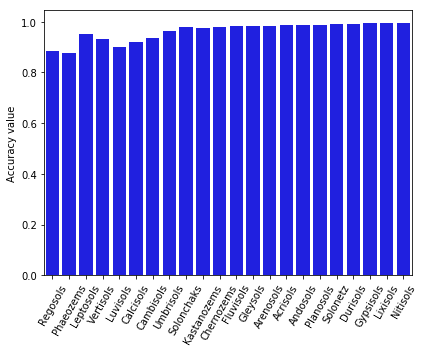

In [52]:
list_values = [d['Accuracy'] for d in list(results.values())]
#list_values = [d['Kappa'] for d in list(results.values())]

plt.figure(figsize=(6,5))
#plt.plot([-0.5, len(results)], [list_values[-1], list_values[-1]], color='red', linestyle='dashed')

sns.barplot(list(results)[1:], list_values[1:], color='blue')

plt.xticks(rotation=60)
plt.ylabel('Accuracy value')
plt.tight_layout()
plt.savefig('one_vs_all.pdf')

22
[0.56410256 0.34328358 0.87610619 0.69230769 0.67647059 0.62244898
 0.25396825 0.58695652 0.93333333 0.08695652 0.04761905 0.05263158
 0.05555556 0.8        0.42857143 0.57142857 0.07142857 0.1
 0.16666667 0.33333333 0.         0.33333333]


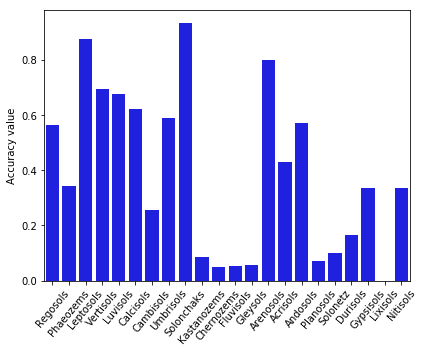

In [53]:
cm = confusion_matrix(y_test, preds_RF_val, labels=list(y.value_counts().index))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()

print(len(list_values[1:]))
improvement = list_values[1:] - cm.diagonal()
print(cm.diagonal())

plt.figure(figsize=(6,5))
sns.barplot(list(results)[1:], cm.diagonal(), color='b')
plt.xticks(rotation=50)
plt.ylabel('Accuracy value')

plt.tight_layout()
plt.savefig('general_rf_accuracy.pdf')

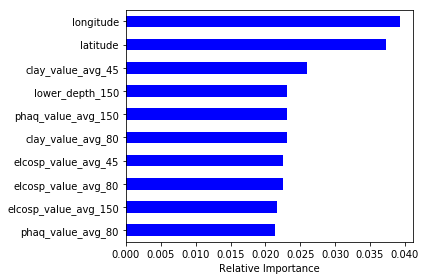

In [159]:
df_ = pd.DataFrame(X.drop('profile_id', axis=1).columns, columns=['feature'])
df_['fscore'] = clf_RF.feature_importances_[:, ]
df_.sort_values('fscore', ascending=False, inplace=True)
df_ = df_[0:10]
df_.sort_values('fscore', ascending=True, inplace=True)
df_.plot(kind='barh', x='feature', y='fscore',
         color='blue', legend=False)
plt.xlabel('Relative Importance')
plt.ylabel('')
plt.tight_layout()
plt.savefig('feature_importance.pdf')

Normalized confusion matrix


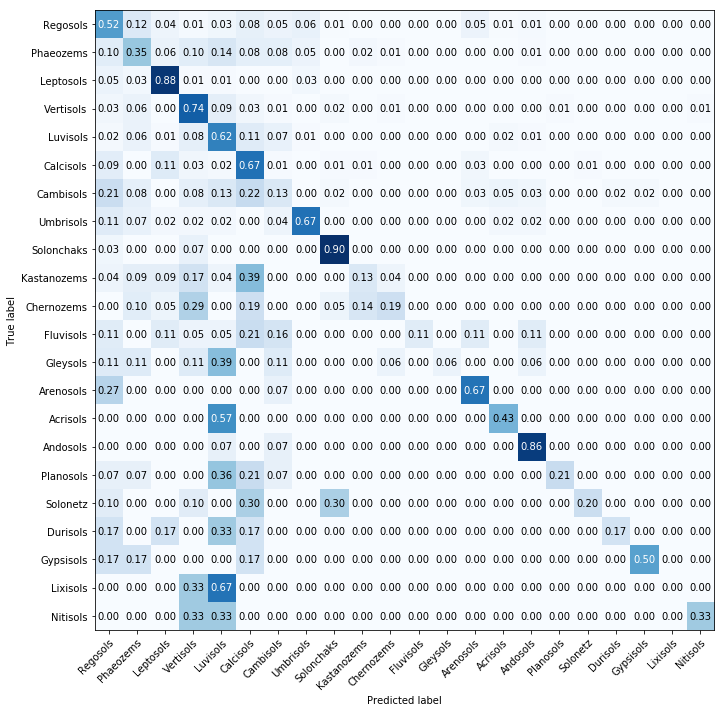

In [161]:

labels = list(y.value_counts().index)
    

plot_confusion_matrix_2(y_test,preds_RF_val, classes=labels)
plt.savefig('confusion_matrix_rf.pdf')